In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 
sns.set()

list_of_columns = [
 'home',
 'away',
 'date',
 'venue',
 'league',
 'part_of_competition',
 'home_score',
 'away_score',
 'home_possessionPct',
 'away_possessionPct',
 'home_shotsSummary',
 'away_shotsSummary',
 'home_foulsCommitted',
 'away_foulsCommitted',
 'home_yellowCards',
 'away_yellowCards',
 'home_redCards',
 'away_redCards',
 'home_offsides',
 'away_offsides',
 'home_wonCorners',
 'away_wonCorners',
 'home_saves',
 'away_saves'
]

def strip_perc_symbol(perc):
    return float(perc.strip('%'))

def shots(shot_summary):
    interm_string = shot_summary.strip(')')
    entries = interm_string.split('(')
    return int(entries[0])

def shots_on_goal(shot_summary):
    interm_string = shot_summary.strip(')')
    entries = interm_string.split('(')
    return int(entries[1])


from sklearn.base import BaseEstimator, TransformerMixin
class FeaturesSubsetter(BaseEstimator, TransformerMixin):
    def __init__(self, subset=True):
        self.subset=subset
    def fit(self, X, y=None):
        return self 
    def transform(self, X):
        if self.subset:
            return X.loc[:, list_of_columns]
        else:
            return X 

class NaDropper(BaseEstimator, TransformerMixin):
    def __init__(self, format=True):
        self.format=format
    def fit(self, X, y=None):
        return self 
    def transform(self, X):
        return X.dropna() 


class PctFormatter(BaseEstimator, TransformerMixin):
    def __init__(self, format=True):
        self.format=format
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if self.format:
            X['home_possessionPct'] = X['home_possessionPct'].apply(strip_perc_symbol)
            X['away_possessionPct'] = X['away_possessionPct'].apply(strip_perc_symbol)

        return X

class SummaryFormatter(BaseEstimator, TransformerMixin):
    def __init__(self, format=True):
        self.format=format
    def fit(self, X, y=None):
        return self 
    def transform(self, X):
        if self.format:
            X['home_shots'] = X['home_shotsSummary'].apply(shots)
            X['home_shots_on_goal'] = X['home_shotsSummary'].apply(shots_on_goal)
            X = X.drop('home_shotsSummary', axis=1)

            X['away_shots'] = X['away_shotsSummary'].apply(shots)
            X['away_shots_on_goal'] = X['away_shotsSummary'].apply(shots_on_goal)
            X = X.drop('away_shotsSummary', axis=1)

        return X


from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

pipeline = Pipeline([
    ('subsetter', FeaturesSubsetter()), 
    ('na_dropper', NaDropper()),
    ('pct_formatter', PctFormatter()), 
    ('summary_formatter', SummaryFormatter())
])
      

num_attribs = [
 'home_possessionPct',
 'away_possessionPct',
 'home_foulsCommitted',
 'away_foulsCommitted',
 'home_yellowCards',
 'away_yellowCards',
 'home_redCards',
 'away_redCards',
 'home_offsides',
 'away_offsides',
 'home_wonCorners',
 'away_wonCorners',
 'home_saves',
 'away_saves', 
 'home_shots',
 'home_shots_on_goal',
 'away_shots',
 'away_shots_on_goal'
]

cat_attribs = [
 'home',
 'away',
 'league'
]



from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

column_transf = ColumnTransformer([
 ("cat", OneHotEncoder(), cat_attribs),
 ("num", StandardScaler(), num_attribs)
 ])



In [2]:
# full_pipeline = Pipeline([
#     ('pipe', pipeline) ,
#     ('col_tr', column_transf)         
# ])
df = pd.read_csv('matches.csv')
df = pipeline.fit_transform(df)
y_1 = df['home_score']
y_2 = df['away_score']
df.drop(['home_score', 'away_score'], axis=1, inplace=True)
matrix = column_transf.fit_transform(df).toarray()


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (11,14,50,102,123,125,129,131,133,135,137,139,141,143,145,147,149,157,158,160,161,163,165,167,169,171,173,184,186,187,205,206) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Binary Clasifiers 

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(matrix, y_1, test_size=0.2)

y_train_0 = (y_train == 0 )
y_test_0 = (y_train > 0)

### Logistic regression 

In [4]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train_0)

from sklearn.model_selection import cross_val_score
cross_val_score(log_reg, X_train, y_train_0, cv=3, scoring="accuracy")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([0.95106551, 0.96606156, 0.95339652])

In [5]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(log_reg, X_train, y_train_0, cv=3)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_0, y_train_pred)


array([[3027,   80],
       [  84,  609]], dtype=int64)

In [6]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_0, y_train_pred) 

0.8838896952104499

In [7]:
recall_score(y_train_0, y_train_pred)

0.8787878787878788

In [8]:
from sklearn.metrics import f1_score
f1_score(y_train_0, y_train_pred)

0.8813314037626627

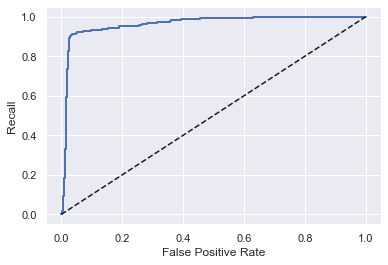

In [29]:
y_scores = cross_val_predict(log_reg, X_train, y_train_0, cv=3,
 method="decision_function")

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_0, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') #
    plt.xlabel("False Positive Rate")
    plt.ylabel("Recall")

plot_roc_curve(fpr, tpr)





In [10]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_0, y_scores)

0.9628586197623854

### Generalization 

In [31]:
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import cross_val_predict
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import precision_score, recall_score
# from sklearn.metrics import f1_score
# from sklearn.metrics import roc_curve
# from sklearn.metrics import roc_auc_score


# def plot_roc_curve(fpr, tpr, label=None):
#     plt.plot(fpr, tpr, linewidth=2, label=label)
#     plt.plot([0, 1], [0, 1], 'k--') #

def evaluate_binary_classifier(classifier):
    print("Cross val scores", cross_val_score(classifier, X_train, y_train_0, cv=3, scoring="accuracy"))
    
    y_train_pred = cross_val_predict(classifier, X_train, y_train_0, cv=3)
    print("Confusion Matrix \n" , confusion_matrix(y_train_0, y_train_pred))

    print("Precision", precision_score(y_train_0, y_train_pred))
    print("Recall", recall_score(y_train_0, y_train_pred))
    print("F1", f1_score(y_train_0, y_train_pred))

    y_scores = cross_val_predict(classifier, X_train, y_train_0, cv=3,method="decision_function")

    fpr, tpr, thresholds = roc_curve(y_train_0, y_scores)
    plot_roc_curve(fpr, tpr)

    print("AUC", roc_auc_score(y_train_0, y_scores))


Cross val scores [0.95106551 0.96606156 0.95339652]
Confusion Matrix 
 [[3027   80]
 [  84  609]]
Precision 0.8838896952104499
Recall 0.8787878787878788
F1 0.8813314037626627
AUC 0.9628586197623854


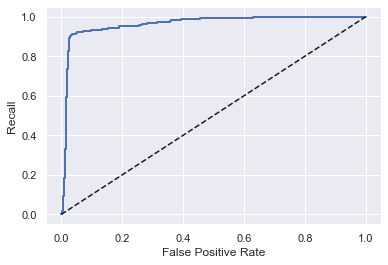

In [32]:
evaluate_binary_classifier(log_reg)

### SVM

#### Linear 

Cross val scores [0.95343331 0.96842936 0.96208531]
Confusion Matrix 
 [[3021   86]
 [  61  632]]
Precision 0.8802228412256268
Recall 0.911976911976912
F1 0.8958185683912121
AUC 0.9609261031855173


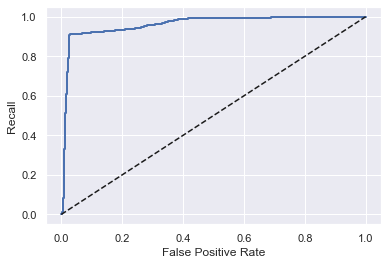

In [33]:
from sklearn.svm import LinearSVC

linsvc = LinearSVC(C=1, loss="hinge")
linsvc.fit(X_train, y_train_0)

evaluate_binary_classifier(linsvc)

#### Linear with polynomial features 

Cross val scores [0.71112865 0.68034728 0.70379147]
Confusion Matrix 
 [[2346  750]
 [ 396  308]]
Precision 0.29111531190926276
Recall 0.4375
F1 0.3496027241770715
AUC 0.9639486250587267


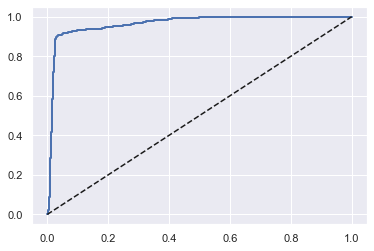

In [15]:
# from sklearn.preprocessing import PolynomialFeatures

# polynomial_svm_clf = Pipeline([
#  ("poly_features", PolynomialFeatures(degree=3)),
#  ("scaler", StandardScaler()),
#  ("svm_clf", LinearSVC(C=10, loss="hinge"))
#  ])

# polynomial_svm_clf.fit(X_train, y_train_0)
# evaluate_binary_classifier(polynomial_svm_clf)

#### Polynomial Kernel

Cross val scores [0.81767956 0.81767956 0.81753555]
Confusion Matrix 
 [[3107    0]
 [ 693    0]]
Precision 0.0
Recall 0.0
F1 0.0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC 0.9276548648933587


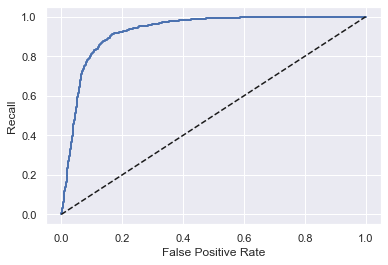

In [35]:
from sklearn.svm import SVC
svc_poly = SVC(kernel='poly', degree=3, coef0=1, C=0.0001)
svc_poly.fit(X_train, y_train_0)

evaluate_binary_classifier(svc_poly)

#### Radial Kernel 

Cross val scores [0.81767956 0.81767956 0.81753555]
Confusion Matrix 
 [[3107    0]
 [ 693    0]]
Precision 0.0
Recall 0.0
F1 0.0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC 0.5


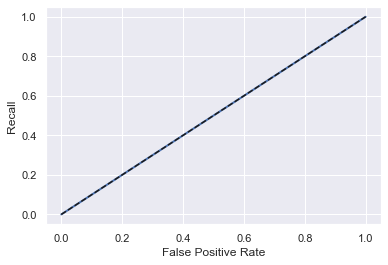

In [45]:
rbf_kernel_svm_clf = SVC(gamma=5, C=0.0000001)
rbf_kernel_svm_clf.fit(X_train, y_train_0)
evaluate_binary_classifier(rbf_kernel_svm_clf)

### Random Forest 

In [43]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=300, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train_0)

evaluate_binary_classifier(rnd_clf)

Cross val scores [0.81767956 0.81767956 0.81753555]
Confusion Matrix 
 [[3107    0]
 [ 693    0]]
Precision 0.0
Recall 0.0
F1 0.0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

### AdaBoost

Cross val scores [0.91239148 0.91949487 0.91390205]
Confusion Matrix 
 [[3035   72]
 [ 250  443]]
Precision 0.8601941747572815
Recall 0.6392496392496393
F1 0.7334437086092715
AUC 0.9541548641967053


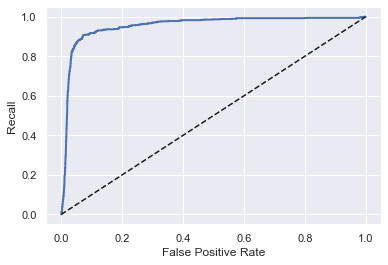

In [38]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
 DecisionTreeClassifier(max_depth=1), n_estimators=200,
 algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(X_train, y_train_0)

evaluate_binary_classifier(ada_clf)


### Voting Classifier

In [39]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
 estimators=[('lr', log_reg), ('ada', ada_clf)],
 voting='hard')
voting_clf.fit(X_train, y_train_0)

evaluate_binary_classifier(voting_clf)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Cross val scores [0.91239148 0.92501973 0.91469194]
Confusion Matrix 
 [[3045   62]
 [ 252  441]]
Precision 0.8767395626242545
Recall 0.6363636363636364
F1 0.7374581939799332


AttributeError: 'VotingClassifier' object has no attribute 'decision_function'

### Grid Search

In [40]:
from sklearn.model_selection import GridSearchCV
param_grid = [
 {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
 {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
 ]
forest_clf = RandomForestClassifier()
grid_search = GridSearchCV(forest_clf, param_grid, cv=5,
 scoring='f1',
return_train_score=True)
grid_search.fit(X_train, y_train_0)

evaluate_binary_classifier(grid_search.best_estimator_)

Cross val scores [0.78768745 0.78137332 0.78593997]
Confusion Matrix 
 [[2863  244]
 [ 560  133]]
Precision 0.35278514588859416
Recall 0.1919191919191919
F1 0.2485981308411215


AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'